In [5]:
from google.colab import drive 
drive.mount("/content/drive/")

Mounted at /content/drive/


In [6]:
import os 
from os import listdir
import torch 
#from torch.utilis import dataset
import torchvision 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.io import read_image
from torch.utils.data import Dataset  
import json
from torch.utils.data import DataLoader
from torch.nn import Module

In [7]:
with open("/content/drive/MyDrive/metadata.json") as jsonfile:
        lables=json.load(jsonfile)

In [8]:
import numpy as np
from scipy.spatial import ConvexHull
def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    from scipy.ndimage.interpolation import rotate
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T
#     rotations = np.vstack([
#         np.cos(angles),
#         -np.sin(angles),
#         np.sin(angles),
#         np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    rval=np.zeros((4,2))
    r = rotations[best_idx]

    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)
    rr=np.zeros((1,4))
    rr[0]=np.array(np.min(rval,0).tolist()+np.max(rval,0).tolist())
  
    return rr

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
class data_loader(Dataset):
    def __init__(self,dir_img,lables_file,Transformation=True):
       self.images=[i for i in listdir(dir_img)if os.path.isfile(os.path.join(dir_img,i))]
       self.labels=[lables[i] for i in self.images]
       self.dir=dir_img
       self.transformation=Transformation
    def __len__(self):
        return len(self.images)
    def __getitem__(self,idx):
      image=read_image(os.path.join(self.dir,self.images[idx]))
      label=[self.labels[idx]['bounds_x_y']]
    
      list_label=np.array([list(i.values()) for i in label[0]])

      rect_label=minimum_bounding_rectangle(list_label)
      
      if self.transformation:
                 image=image/225
      target={}
      target["boxes"]=torch.tensor(rect_label,dtype=torch.float64).to(device)
      target["labels"]=torch.tensor([1]).to(device)
      image=image.to(device)
      return (image,target)

In [10]:
def collect_fn(data):
      D=[i[0] for i in data]
      target=[i[1] for i in data]
    
      return [D,target]

     

In [11]:
import gc

gc.collect()

torch.cuda.empty_cache()

torch.cuda.empty_cache()

In [12]:
train_data=data_loader("/content/drive/MyDrive/AAA/images",lables)
#train_data_loader=DataLoader(train_data, batch_size=60, shuffle=True,collate_fn=collect_fn)
train_size = int(0.8 * len(train_data))
test_size = len(train_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_data, [train_size, test_size])
train_dataset=DataLoader(train_dataset,batch_size=10, shuffle=True,collate_fn=collect_fn)
test_dataset=DataLoader(test_dataset,batch_size=10, shuffle=True,collate_fn=collect_fn)

In [9]:
for data in next(iter(train_dataset)):
              print(data[0].shape)
              break 

torch.Size([3, 512, 512])


In [13]:
def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model =torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=False,num_classes=2,trainable_backbone_layers=0)
    
    # get the number of input features 
    #in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    #model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [14]:
from torch import nn

In [12]:
class detector(nn.module):
      def __init__(self,chanel_ine, chanel_out_feature_backbone, ):
          super(detector.self).__init__():
          self.depth=feature_channels 
          


SyntaxError: ignored

In [15]:
model =create_model(2)
model.to(device)
#img, target=next(iter(train_data_loader))
#output=model(img,target)
creterion=torch.nn.MSELoss()

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

In [ ]:
 params = [p for p in model.parameters() if p.requires_grad]
 optimizer = torch.optim.SGD(params, lr=0.01,momentum=0.9, weight_decay=0.0005)
 num_epochs = 10
 for epoch in range(num_epochs):
 
       model.train()
  
       epoch_loss = 0
       for data,target in iter(train_dataset):
  
          print("a")
        
          output=model(data,target)
     
 
          total_loss=sum(list(output.values()))
          optimizer.zero_grad()
          total_loss.backward()

          optimizer.step() 
     

In [ ]:
model.eval()
eval_loss=0
with torch.no_grad():
  for data,target in iter(test_dataset):
          predictions = model(data)
          for i in range(len(predictions)):
        
                a=creterion(predictions[i]["boxes"],target[i]["boxes"])
                if a>0 or a<0:
                   eval_loss+=a
print("{}_evaluation_loss_{}".format(epoch,eval_loss/len(test_dataset)))

In [30]:
predictions[i-3]["boxes"]

IndexError: ignored

In [26]:
target

[{'boxes': tensor([[208.1136, 195.7472, 303.5114, 288.2528]], device='cuda:0',
         dtype=torch.float64), 'labels': tensor([1], device='cuda:0')},
 {'boxes': tensor([[224.4869, 206.1775, 293.0323, 284.0971]], device='cuda:0',
         dtype=torch.float64), 'labels': tensor([1], device='cuda:0')}]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


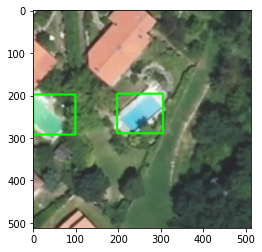

In [94]:
import matplotlib.pyplot as plt
img_ = np.transpose(np.copy(data[i].cpu()),(1,2,0))
import cv2
for i, bbox in enumerate(predictions[i]["boxes"]):
    cv2.rectangle(img_, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color=(0, 255, 0), thickness=3) 
plt.imshow(img_)
plt.show()   

In [89]:
np.permute

AttributeError: ignored

In [85]:
img_.shape

(3, 512, 512)

In [25]:
bbox

tensor([208.1136, 195.7472, 303.5114, 288.2528], device='cuda:0',
       dtype=torch.float64)

In [65]:
 model.eval()
 for data,target in iter(test_dataset):
          predictions = model(data)
          break 

In [66]:
   predictions[0]["boxes"]

tensor([[197.5441, 196.1072, 305.2000, 289.7547],
        [  0.0000, 198.5228,  99.2335, 292.5556]], device='cuda:0',
       grad_fn=<StackBackward0>)

In [ ]:
target

In [83]:
img_ = data[0]
import cv2
for i, bbox in enumerate( predictions[0]["boxes"]):
    cv2.rectangle(img_.cpu(), (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color=(0, 255, 0), thickness=3) 
plt.imshow(img_)
plt.show()   

TypeError: ignored

In [79]:
bbox[2]

tensor(305.2000, device='cuda:0', grad_fn=<SelectBackward0>)

In [71]:
predictions[0]["boxes"][0]

tensor([197.5441, 196.1072, 305.2000, 289.7547], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [74]:
bbox

tensor([197.5441, 196.1072, 305.2000, 289.7547], device='cuda:0',
       grad_fn=<UnbindBackward0>)